## Imported Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
pd.set_option("display.max_rows", 200)

## Read CSV File

In [3]:
df = pd.read_csv("FIES PUF 2012 Vol.1.CSV")
df

,W_REGN,W_OID,W_SHSN,W_HCN,URB,RSTR,PSU,BWEIGHT,RFACT,FSIZE,...,PC_QTY,OVEN_QTY,MOTOR_BANCA_QTY,MOTORCYCLE_QTY,POP_ADJ,PCINC,NATPC,NATDC,REGDC,REGPC
0,14,101001000,2,25,2,21100,415052,138.25,200.6576,3.0,...,01,01,,,0.946172,108417.00,9,8,8,9
1,14,101001000,3,43,2,21100,415052,138.25,200.6576,12.5,...,,01,,01,0.946172,30631.60,5,9,9,4
2,14,101001000,4,62,2,21100,415052,138.25,200.6576,2.0,...,,01,,,0.946172,86992.50,9,6,6,8
3,14,101001000,5,79,2,21100,415052,138.25,200.6576,4.0,...,,01,,,0.946172,43325.75,6,6,6,6
4,14,101001000,10,165,2,21100,415052,138.25,200.6576,5.0,...,,,,01,0.946172,37481.80,6,6,6,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40166,12,9804029001,18,568,1,22000,114062,271.25,963.2264,5.0,...,00,00,00,00,0.902863,30101.60,5,5,7,7
40167,12,9804035000,1,25,2,22000,414067,271.25,588.6253,9.0,...,00,01,00,00,0.902863,14368.89,1,5,7,3
40168,12,9804035000,2,51,2,22000,414067,271.25,588.6253,6.0,...,00,00,00,00,0.902863,19137.33,3,4,6,4
40169,12,9804035000,3,75,2,22000,414067,271.25,588.6253,5.0,...,00,01,00,00,0.902863,30985.00,5,6,7,7


## Data Cleaning
* W_REGN
* NONAGRI_SAL
* EMPLOYED_PAY
* OCCUP
* JOB




In [4]:
# Get only people who have jobs
selected_df = df[["W_REGN","W_OID","W_SHSN","W_HCN","NONAGRI_SAL","EMPLOYED_PAY","OCCUP","JOB","SEX"]]

In [5]:
selected_df = selected_df.drop_duplicates()

In [6]:
selected_df = selected_df.dropna(subset=["OCCUP"])

In [7]:
selected_df = selected_df[selected_df["JOB"] != 2]

In [8]:
selected_df = selected_df[selected_df["NONAGRI_SAL"] > 0]


In [9]:
selected_df.loc[:, "EMPLOYED_PAY"] = pd.to_numeric(selected_df["EMPLOYED_PAY"], errors='coerce')
selected_df.loc[:, "EMPLOYED_PAY"] = selected_df["EMPLOYED_PAY"].fillna(0).astype(int)
employed_df = selected_df[["EMPLOYED_PAY"]]

C:\Users\Joshua\AppData\Local\Temp\ipykernel_17772\1621606931.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  selected_df.loc[:, "EMPLOYED_PAY"] = selected_df["EMPLOYED_PAY"].fillna(0).astype(int)


In [10]:
selected_df = selected_df[selected_df["EMPLOYED_PAY"] == 1]

In [11]:
# Remove the Farmers, Forestry Worker,Fishermen since they are counted as agricultural workers but they they are not categorized
#  as agricultural workers since they earn earn salaries based on non-agricultural salary
selected_df = selected_df[selected_df['OCCUP'] != "6111"]

In [12]:
clean_df = selected_df
# clean_df
selected_df

,W_REGN,W_OID,W_SHSN,W_HCN,NONAGRI_SAL,EMPLOYED_PAY,OCCUP,JOB,SEX
4,14,101001000,10,165,32000,1,5220,1,1
27,14,101030001,1,1,63246,1,1130,1,1
33,14,101030001,12,191,293556,1,2331,1,2
34,14,101030001,14,222,33000,1,1316,1,1
41,14,101031000,4,61,98300,1,7231,1,1
...,...,...,...,...,...,...,...,...,...
40160,12,9804029001,7,213,72000,1,9132,1,1
40164,12,9804029001,15,8005,54300,1,1314,1,1
40165,12,9804029001,17,537,58100,1,8321,1,1
40167,12,9804035000,1,25,50400,1,8321,1,1


## EDA Questions

* How does the average salary of the top job type in each region compare to the region's overall average salary?
* Which region has the highest overall average salary for non-agricultural jobs?
* What occupation has the most employed in the dataset across all regions
* Is there a notable difference in the salary distribution by gender for sole earners in non-agricultural roles?


Q1: How does the average salary of the top job type in each region compare to the region's overall average salary?

In [13]:
# Calculate the average salary for each job type by region
avg_salary_by_job = selected_df.groupby(['W_REGN', 'OCCUP'])['NONAGRI_SAL'].mean().reset_index()

In [14]:
# Get the top job type for each region based on average salary
top_job_by_region = avg_salary_by_job.loc[avg_salary_by_job.groupby('W_REGN')['NONAGRI_SAL'].idxmax()]

In [15]:
# Calculate the overall average salary for each region
overall_avg_salary = selected_df.groupby('W_REGN')['NONAGRI_SAL'].mean().reset_index()
overall_avg_salary.columns = ['W_REGN', 'Overall_Avg_Salary']

In [16]:
# Merge the top job salary and overall average salary
comparison_df = pd.merge(top_job_by_region, overall_avg_salary, on='W_REGN', how='inner')

In [17]:
# Rename the columns for clarity
comparison_df.columns = ['W_REGN', 'Top_Occupation', 'Top_Avg_Salary', 'Overall_Avg_Salary']

In [18]:
# Display the resulting DataFrame
comparison_df

,W_REGN,Top_Occupation,Top_Avg_Salary,Overall_Avg_Salary
0,1,2152,1019606.0,83266.892694
1,2,1412,518500.0,101307.356902
2,3,3450,719536.0,110484.808568
3,5,1110,574575.0,68173.927798
4,6,1226,872000.0,85413.229617
5,7,6113,418800.0,84079.386623
6,8,1430,627600.0,69454.105634
7,9,1411,595200.0,81571.986577
8,10,2152,1094600.0,93837.728889
9,11,1429,1200410.0,95818.950820


## Numerical Summaries

In [19]:
# Calculate numerical summaries for Top Average Salary
top_avg_salary_mean = comparison_df['Top_Avg_Salary'].mean()
top_avg_salary_median = comparison_df['Top_Avg_Salary'].median()
top_avg_salary_std = comparison_df['Top_Avg_Salary'].std()
top_avg_salary_range = comparison_df['Top_Avg_Salary'].max() - comparison_df['Top_Avg_Salary'].min()

# Calculate numerical summaries for Overall Average Salary
overall_avg_salary_mean = comparison_df['Overall_Avg_Salary'].mean()
overall_avg_salary_median = comparison_df['Overall_Avg_Salary'].median()
overall_avg_salary_std = comparison_df['Overall_Avg_Salary'].std()
overall_avg_salary_range = comparison_df['Overall_Avg_Salary'].max() - comparison_df['Overall_Avg_Salary'].min()

# Displaying the numerical summaries
print("Numerical Summaries for Top Average Salary:")
print(f"  Mean: {top_avg_salary_mean:.2f}")
print(f"  Median: {top_avg_salary_median:.2f}")
print(f"  Standard Deviation: {top_avg_salary_std:.2f}")
print(f"  Range: {top_avg_salary_range:.2f}")

print("\nNumerical Summaries for Overall Average Salary:")
print(f"  Mean: {overall_avg_salary_mean:.2f}")
print(f"  Median: {overall_avg_salary_median:.2f}")
print(f"  Standard Deviation: {overall_avg_salary_std:.2f}")
print(f"  Range: {overall_avg_salary_range:.2f}")


Numerical Summaries for Top Average Salary:
  Mean: 828687.47
  Median: 719536.00
  Standard Deviation: 417045.04
  Range: 1625312.00

Numerical Summaries for Overall Average Salary:
  Mean: 94167.16
  Median: 85413.23
  Standard Deviation: 22960.56
  Range: 91543.74


## Findings from Numerical Summaries

### Top Average Salary
The following are the numerical summaries for the top average salary across different occupations by region:

- **Mean**: 828,687.47
- **Median**: 719,536.00
- **Standard Deviation**: 417,045.04
- **Range**: 1,625,312.00

The analysis of the top average salary of non-agricultural jobs across different occupations by region reveals a mean salary of 828,687.47, with a median of 719,536.00, indicating a right-skewed distribution. The standard deviation of 417,045.04 suggests considerable variability in salaries, while the range of 1,625,312.00 highlights significant disparities in earnings across occupations.

### Overall Average Salary
The following are the numerical summaries for the overall average salary by region:

- **Mean**: 94,167.16
- **Median**: 85,413.23
- **Standard Deviation**: 22,960.56
- **Range**: 91,543.74

In contrast, the overall average salary by region has a much lower mean of 94,167.16 and a median of 85,413.23, reflecting the more common income levels. The standard deviation of 22,960.56 indicates less variability compared to the top average salaries, and the range of 91,543.74 suggests a narrower disparity in overall salaries.

## Visualization

In [20]:
# Data for Top Average Salary of Non-Agricultural Jobs
top_avg_salary = pd.DataFrame({
    'Statistic': ['Mean', 'Median', 'Standard Deviation', 'Range'],
    'Value': [top_avg_salary_mean, top_avg_salary_median, top_avg_salary_std, top_avg_salary_range]
})

# Data for Overall Average Salary by Region
overall_avg_salary = pd.DataFrame({
    'Statistic': ['Mean', 'Median', 'Standard Deviation', 'Range'],
    'Value': [overall_avg_salary_mean, overall_avg_salary_median, overall_avg_salary_std, overall_avg_salary_range]
})

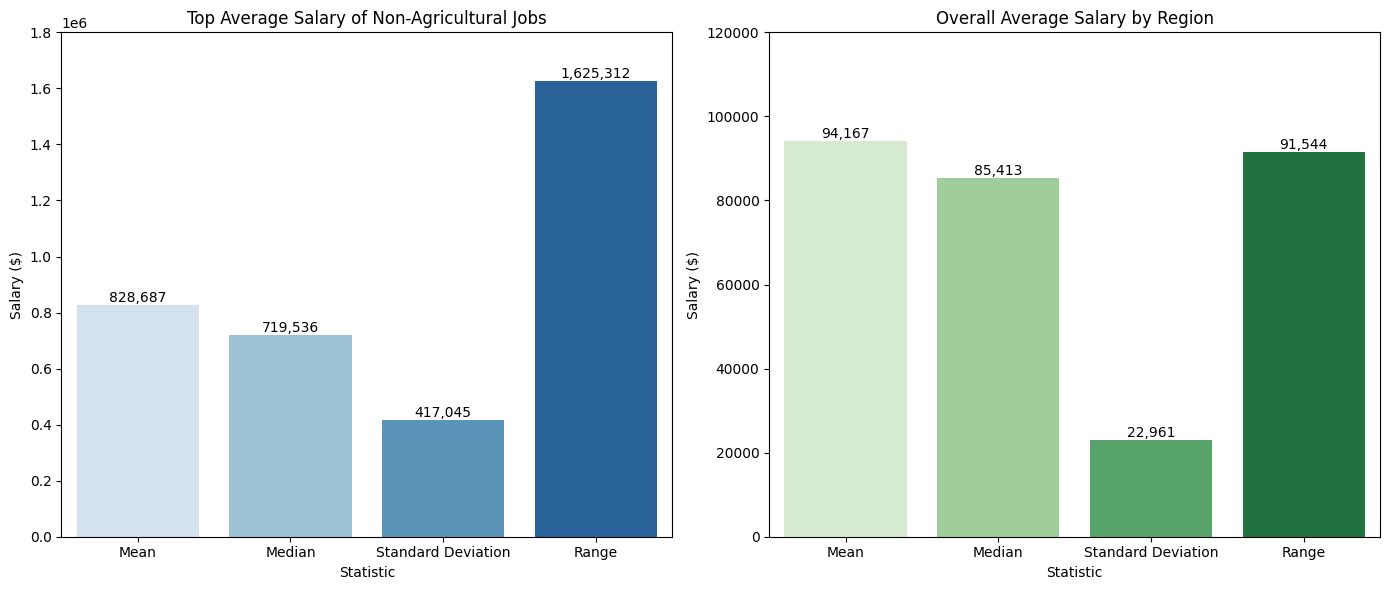

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Visualization for Top Average Salary
sns.barplot(x='Statistic', y='Value', hue='Statistic', data=top_avg_salary, ax=ax[0], palette='Blues', dodge=False, legend=False)
ax[0].set_title('Top Average Salary of Non-Agricultural Jobs')
ax[0].set_ylabel('Salary ($)')
ax[0].set_ylim(0, 1800000)
for p in ax[0].patches:
    ax[0].annotate(f'{p.get_height():,.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='bottom', fontsize=10)

sns.barplot(x='Statistic', y='Value', hue='Statistic', data=overall_avg_salary, ax=ax[1], palette='Greens', dodge=False, legend=False)
ax[1].set_title('Overall Average Salary by Region')
ax[1].set_ylabel('Salary ($)')
ax[1].set_ylim(0, 120000)
for p in ax[1].patches:
    ax[1].annotate(f'{p.get_height():,.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


## Findings from Visualization

### Top Average Salary
From the first bar chart, we can observe that:

- **Mean Salary** is significantly higher than the median, indicating that there are high-paying jobs that raise the overall average.

- **Standard Deviation** is substantial, suggesting a wide variation in salaries, which implies that certain jobs within the top-paying category have extremely high earnings compared to others.
Range shows the difference between the highest and lowest top average salaries, highlighting a broad spectrum of earning potentials within this category.

- **Range** shows the difference between the highest and lowest top average salaries, highlighting a broad spectrum of earning potentials within this category.

### Overall Average Salary
From the second bar char, we can observe that:

- **Mean and Median Salaries** are relatively close, suggesting a more consistent distribution of salaries across regions.

- **Lower Standard Deviation** indicates that there is less variation in salaries, meaning that most regions have average salaries clustered around the mean.

- **Range** is narrower compared to the top average salaries, which reflects less disparity between the highest and lowest overall average salaries across different regions.

Q2: Which Region has the highest overall average salary for non-agricultural jobs?

In [22]:
grouped_regions = clean_df.groupby(["W_REGN"])
grouped_regions = grouped_regions.agg({"NONAGRI_SAL" : "mean"})
grouped_regions

,NONAGRI_SAL
W_REGN,
1,83266.892694
2,101307.356902
3,110484.808568
5,68173.927798
6,85413.229617
7,84079.386623
8,69454.105634
9,81571.986577
10,93837.728889


In [23]:
highest_mean_salary = grouped_regions["NONAGRI_SAL"].max()
highest_region = grouped_regions["NONAGRI_SAL"].idxmax()
print(f"Region {highest_region} has the highest mean non-agricultural salary: ", "{:.2f}".format(highest_mean_salary))

Region 13 has the highest mean non-agricultural salary:  159717.67


## Visualization

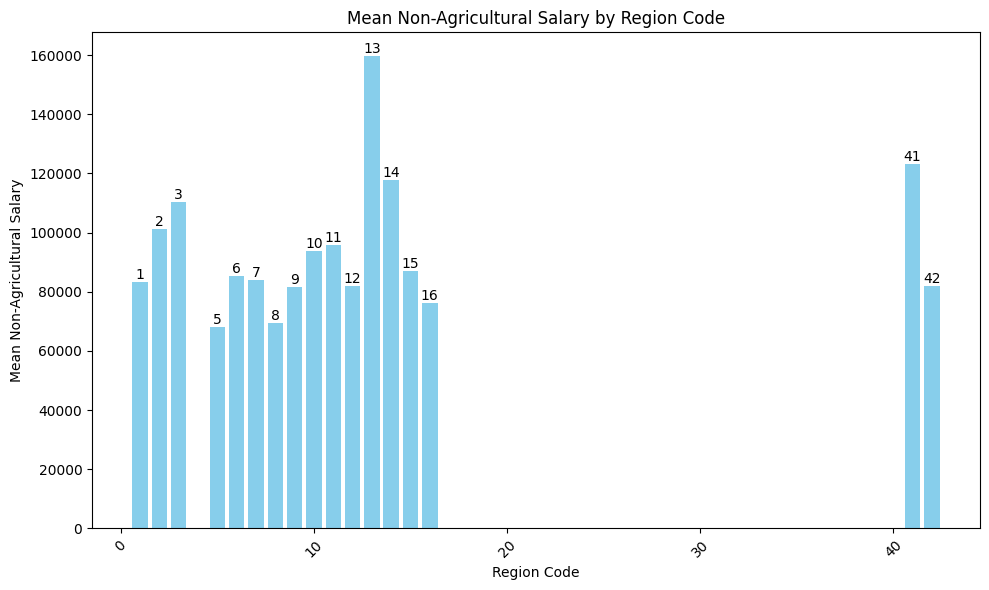

In [40]:
#Visualization
region_salaries = {
    1: 83266.89, 2: 101307.36, 3: 110484.81, 5: 68173.93, 6: 85413.23,
    7: 84079.39, 8: 69454.11, 9: 81571.99, 10: 93837.73, 11: 95818.95,
    12: 81904.15, 13: 159717.67, 14: 117868.63, 15: 86950.40, 16: 76156.77,
    41: 123046.28, 42: 81789.37
}

grouped_regions = pd.DataFrame(list(region_salaries.items()), columns=["W_REGN", "NONAGRI_SAL"])

plt.figure(figsize=(10, 6))
bars = plt.bar(grouped_regions["W_REGN"], grouped_regions["NONAGRI_SAL"], color='skyblue')

plt.xlabel('Region Code')
plt.ylabel('Mean Non-Agricultural Salary')
plt.title('Mean Non-Agricultural Salary by Region Code')

for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, 
             f'{grouped_regions["W_REGN"][i]}', ha='center', va='bottom')

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Q3: What occupation has the most employed in the dataset across all regions
-- mode for each occupation
-- sort
-- get top 10

In [25]:
# MALI code sa QUESTION 3 ayusin later
grouped_occupations = clean_df[["OCCUP"]]
grouped_occupations

,OCCUP
4,5220
27,1130
33,2331
34,1316
41,7231
...,...
40160,9132
40164,1314
40165,8321
40167,8321


In [42]:
# Get the most common occup
most_common_occup = grouped_occupations["OCCUP"].value_counts().idxmax()
print(most_common_occup)

1314


In [41]:
most_common_count = grouped_occupations["OCCUP"].value_counts().max()
print(most_common_count)

500


In [28]:
print(f"ID of the most common occupation = {most_common_occup} with count {most_common_count}")

ID of the most common occupation = 1314 with count 500


Since the ID 1314 = Farmers, forestry workers and fishermen


In [29]:
# Add a bar graph

Q4: Is there a notable difference in the salary distribution by gender for sole earners in non-agricultural roles?
* H0: THe distribution of the two groups are equal (two groups have the same median)
* HA: THe distribution fo the two groups are not equal (two groups' median differ)

In [30]:
grouped_sex = clean_df.groupby(["SEX"])
aggregated_group_sex = grouped_sex.agg({"NONAGRI_SAL" : ["median", "count"]})
aggregated_group_sex

NONAGRI_SAL      
         median count
SEX                  
1       74880.0  7843
2       61025.0  1564

In [31]:
sex_groups_only = clean_df.drop(columns=["W_REGN", "W_OID","W_SHSN","W_HCN","EMPLOYED_PAY", "OCCUP","JOB"])

In [32]:
# Get Male and Female in separate dataframe


male_group = sex_groups_only[sex_groups_only["SEX"] == 1]
female_group = sex_groups_only[sex_groups_only["SEX"] == 2]

# male_group
# female_group

In [33]:
male_group = male_group.drop(columns=["SEX"])
# male_group

In [34]:
female_group = female_group.drop(columns=["SEX"])
# female_group

Mann-Whitney U distribution used to find median ranks of two groups that assumes that there's no normality and variance are not equal. since may outliers sa data we can use this 

In [35]:
u_test, p_value = mannwhitneyu(male_group,female_group)
print(u_test)
print(p_value)

[6437166.5]
[0.00193944]


In [36]:
alpha1 = 0.05
if (p_value < alpha1).all():
    print("Reject Null Hypothesis, There is significant difference between groups")
else:
    print("Fail to reject the null hypothesis, There is no significant difference between groups")

Reject Null Hypothesis, There is significant difference between groups


In [37]:
# Add a bar Graph

Q5: 

## Research Question
__1. What type of job has the highest average salary in each region, considering only individuals who work in non-agricultural jobs?__